<img src="https://raw.githubusercontent.com/earthdaily/Images/main/Corporate/EarthDaily.png" width="20%" alt="EarthDaily Analytics">

# Working with EarthDaily DataCubes
__________________
<a href="https://earthdaily.com/contact/">Give Feedback</a> | <a href="https://github.com/earthdaily">Bug report</a>

**Tags:** #EDS, #EarthMosaics, #EarthDailyConstellation, #EDC, #EarthDailyPython

**Authors**: EarthDaily Analytics

**Last update:** 2024-12-23 (Created: 2024-12-23)

**References:**
- [Earth Daily package](https://github.com/earthdaily/earthdaily-python-client)
- [Earth Data Store documentation](https://earthdaily.github.io/EDA-Documentation/)

## Introduction
EarthDaily Analytics offers access to several [STAC-compliant](https://stacspec.org/en) catalogs of raster data, such as [EarthMosaics](https://earthdaily.com/product-service/earthmosaics/) and [VENuS](https://earthdaily.com/earthdaily-ven%C2%B5s-l2a-cloud-optimized-geotiffs/), as well as maintains development of the [EarthDaily Python Client](https://pypi.org/project/earthdaily/), which acts as a user-friendly access interface to retrieve pixel data as [xarray](https://docs.xarray.dev/en/stable/) objects. Furthermore, xarray datasets returned through the EarthDaily Python Client have several unique features and functionality improvements for convenient remote sensing shorthand analysis. 

## Objectives
This notebook covers details and methods specific to datasets retrieved from the EarthDaily Earth Data Store, covering:
* Native index calculations
* Plotting features
* Zonal Statistics

Import dependencies

In [2]:
import geopandas as gpd
import spyndex
from dotenv import load_dotenv
from odc.stac import stac_load
from shapely.geometry import box

from earthdaily import EDSClient, EDSConfig
from earthdaily.datacube._indices import add_indices
from earthdaily.datacube._visualization import plot_band, plot_rgb
from earthdaily.datacube._zonal import compute_zonal_stats

### Connecting to EarthDataStore

Loading in environment variables, please update the associated [`EDS.env`](EDS.env), which can be downloaded from the [EarthDaily Account Management page](https://console.earthdaily.com/account).

In [3]:
load_dotenv("EDS.env", override=True)

True

In [4]:
client = EDSClient(EDSConfig())

### Search for Imagery

In [5]:
bbox = (-52.38175462, -29.85496458, -52.07547469, -29.61356083)
start_date = "2024-02-01"
end_date = "2024-12-01"

gdf = gpd.GeoDataFrame({"geometry": [box(*bbox)]}, crs="epsg:4326")

> _**Note:**_ Here we import a small utility function which replaces S3 HREFs with public HTTPS URLs.

In [6]:
from utils import replace_alternate_href

In [7]:
items = client.platform.pystac_client.search(
    collections=["ai-ready-mosaics-sample"], datetime=f"{start_date}/{end_date}", bbox=bbox
)
items_list = list(items.get_all_items())
# Apply href function
[replace_alternate_href(item) for item in items_list]
print(f"Found unique {len(items_list)} items")
items_list

Found unique 2 items


[<Item id=EDA_Mosaic_M_L2A_EM_Mosaic_F9QkJ>,
 <Item id=EDA_Mosaic_M_L2A_EM_Mosaic_8YNF2>]

### Retrieve DataCube

In [8]:
ds = stac_load(
    items_list,
    bands=("red", "green", "blue", "nir08"),
    intersects=gdf,
    crs="epsg:3857",
    resolution=10,
)
ds

<xarray.Dataset> Size: 169MB
Dimensions:      (y: 3096, x: 3411, time: 2)
Coordinates:
  * y            (y) float64 25kB -3.454e+06 -3.454e+06 ... -3.485e+06
  * x            (x) float64 27kB -5.831e+06 -5.831e+06 ... -5.797e+06
  * time         (time) datetime64[ns] 16B 2024-02-21T13:40:29.936000 2024-05...
    spatial_ref  int32 4B 3857
Data variables:
    red          (time, y, x) uint16 42MB 1216 1201 1187 1186 ... 1074 1070 1073
    green        (time, y, x) uint16 42MB 1388 1365 1312 1309 ... 1092 1082 1085
    blue         (time, y, x) uint16 42MB 1130 1118 1101 1107 ... 1009 1030 1025
    nir08        (time, y, x) uint16 42MB 4259 4171 4171 3993 ... 2573 2573 2556

# EarthDaily Datacube Utilities
The EarthDaily Python Client provides convenient utility functions for working with xarray Datasets, including plotting, index calculation, and zonal statistics.

### Plotting RGB
Use the `plot_rgb` function for convenient RGB visualization:

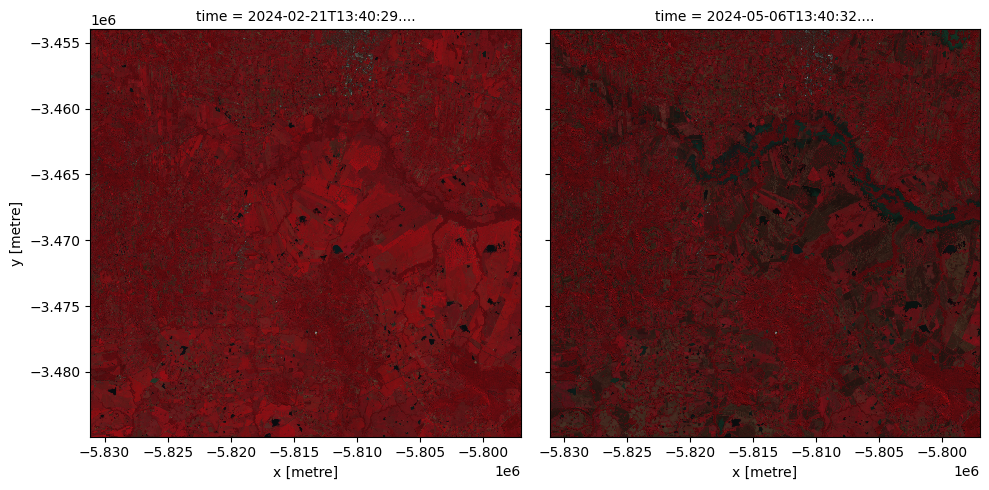

In [9]:
plot_rgb(ds, red="nir08", green="red", blue="green", figsize=(10, 5))

### Index Calculation
Use the [Spyndex API](https://spyndex.readthedocs.io/en/latest/reference.html#spyndex-spyndex) for spectral index calculations. You can browse available indices:

In [10]:
list(spyndex.indices.keys())[:20]

['AFRI1600',
 'AFRI2100',
 'ANDWI',
 'ARI',
 'ARI2',
 'ARVI',
 'ATSAVI',
 'AVI',
 'AWEInsh',
 'AWEIsh',
 'BAI',
 'BAIM',
 'BAIS2',
 'BCC',
 'BI',
 'BITM',
 'BIXS',
 'BLFEI',
 'BNDVI',
 'BRBA']

Add NDVI band to the dataset using `add_indices`:

In [11]:
ds = add_indices(ds, ["NDVI"], N=ds["nir08"], R=ds["red"])

### Plotting Single-Band Imagery
Use the `plot_band` function for inspecting single-band images:

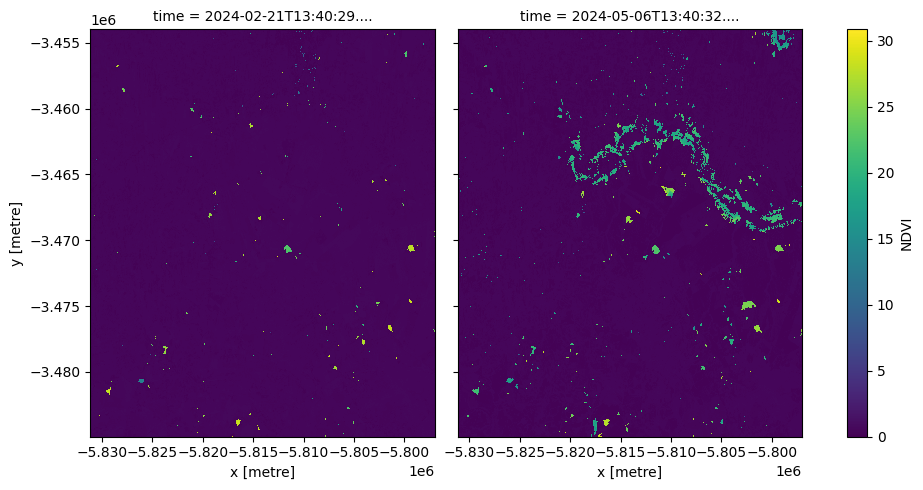

In [12]:
plot_band(ds, "NDVI", figsize=(10, 5), cmap="viridis")

### Zonal Statistics
Use the `compute_zonal_stats` function to compute basic summary statistics for a given index:

In [13]:
ds_mean = compute_zonal_stats(ds, gdf)

In [14]:
ds_mean["NDVI"].to_numpy()

array([[[0.58531261]],

       [[0.87621832]]])

In [15]:
## TODO: Mask polygons - NDVI over fields, reference more advanced use cases in markdown